In [1]:
import tensorflow as tf
import cv2
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from utils.read_tfrecord import tfrecord_auto_traversal, read_tf_records
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imshow

In [2]:
log_dir = './logs/'
tmp = './tmp/'
tfrecord_dir = './TFRecords'
ckpt_name = 'color'
batch_size = 24
num_images = len(os.listdir('./Dataset/'))

In [3]:
tfrecords = tfrecord_auto_traversal('./TFRecords', os.listdir('./TFRecords'))
tfrecords.sort()
print(tfrecords)

9 files were found under ./TFRecords folder. 
Please be noted that only files ending with '*.tfrecord' will be loaded!
Found val-00000-00001.tfrecord successfully!
Found train-00005-00008.tfrecord successfully!
Found train-00004-00008.tfrecord successfully!
Found train-00000-00008.tfrecord successfully!
Found train-00006-00008.tfrecord successfully!
Found train-00003-00008.tfrecord successfully!
Found train-00001-00008.tfrecord successfully!
Found train-00002-00008.tfrecord successfully!
Found train-00007-00008.tfrecord successfully!
Found 9 files:
 ['val-00000-00001.tfrecord', 'train-00005-00008.tfrecord', 'train-00004-00008.tfrecord', 'train-00000-00008.tfrecord', 'train-00006-00008.tfrecord', 'train-00003-00008.tfrecord', 'train-00001-00008.tfrecord', 'train-00002-00008.tfrecord', 'train-00007-00008.tfrecord']



['./TFRecords/train-00000-00008.tfrecord', './TFRecords/train-00001-00008.tfrecord', './TFRecords/train-00002-00008.tfrecord', './TFRecords/train-00003-00008.tfrecord', './

In [4]:
if False:

    with tf.name_scope('batch'):
        for j in range(1,2):
            batch_x, batch_y = read_tf_records(tfrecords[j], batch_size=32)


    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        #saver = tf.train.Saver()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        batch_image, batch_label = sess.run([batch_x, batch_y])
        #a = sess.run(logits, feed_dict={'DecodeJpeg:0': batch_image})
        print(batch_image.shape)
        img = batch_image[0].reshape(512, 512, 1)
        out = batch_label[0].reshape(512, 512, 2)
        image = np.zeros((512, 512, 3))
        image[:, :, 0] = img[:, :, 0]
        image[:, :, 1] = out[:, :, 0]
        image[:, :, 2] = out[:, :, 1]
        
        image = lab2rgb(image)
        imshow(image)
        coord.request_stop()
        coord.join(threads)

# Preparing our model architecture

In [5]:
def COLOR(X):

    initializer = tf.contrib.layers.xavier_initializer()
    
    X = tf.cast(tf.reshape(X, shape=[-1, 512, 512, 1]), tf.float32)

    with tf.name_scope('COLOR_1'):
        
        with tf.variable_scope('COLOR1_PARAMS', reuse=tf.AUTO_REUSE):
            w_conv1 = tf.Variable(initializer([3, 3, 1, 8], dtype=tf.float32), name='w_color1')
            b_conv1 = tf.Variable(tf.random_normal([8], dtype=tf.float32), name='b_color1')
            
        with tf.name_scope('COLOR1_OPS'):
            with tf.name_scope('conv_layer'):
                conv1 = tf.nn.relu( tf.add(tf.nn.conv2d(X, w_conv1, strides=[1, 1, 1, 1], padding='SAME'), b_conv1),
                                   name='conv_1')


    with tf.name_scope('COLOR_2'):
        
        with tf.variable_scope('COLOR2_PARAMS', reuse=tf.AUTO_REUSE):
            w_conv2 = tf.Variable(initializer([3, 3, 8, 16], dtype=tf.float32), name='w_color2')
            b_conv2 = tf.Variable(tf.random_normal([16], dtype=tf.float32), name='b_color2')
            
        with tf.name_scope('COLOR2_OPS'):
            with tf.name_scope('conv_layer'):
                conv2 = tf.nn.relu(tf.add(tf.nn.conv2d(conv1, w_conv2, strides=[1, 2, 2, 1], padding='SAME'), 
                                          b_conv2), name='conv2')

    with tf.name_scope('COLOR_3'):
        
        with tf.variable_scope('COLOR3_PARAMS', reuse=tf.AUTO_REUSE):
            w_conv3 = tf.Variable(initializer([3, 3, 16, 32], dtype=tf.float32), name='w_color3')
            b_conv3 = tf.Variable(tf.random_normal([32], dtype=tf.float32), name='b_color3')
            
        with tf.name_scope('COLOR3_OPS'):
            with tf.name_scope('conv_layer'):
                conv3 = tf.nn.relu(tf.add(tf.nn.conv2d(conv2, w_conv3, strides=[1, 2, 2, 1], padding='SAME'), 
                                          b_conv3), name='conv3')

    with tf.name_scope('COLOR_4'):
        
        with tf.variable_scope('COLO_PARAMS', reuse=tf.AUTO_REUSE):
            w_conv4a = tf.Variable(initializer([5, 1, 32, 64], dtype=tf.float32), name='w_color4a')
            b_conv4a = tf.Variable(tf.random_normal([64], dtype=tf.float32), name='b_color4a')
            
            w_conv4b = tf.Variable(initializer([1, 5, 64, 128], dtype=tf.float32), name='w_conv4b')
            b_conv4b = tf.Variable(tf.random_normal([128], dtype=tf.float32), name='b_color4b')
            
        with tf.name_scope('COLOR4_PARAMS'):
            with tf.name_scope('conv_layer4a'):
                conv4a = tf.nn.relu(tf.add(tf.nn.conv2d(conv3, w_conv4a, strides=[1, 1, 1, 1], padding='SAME'), 
                                           b_conv4a), name='conv4a')

            with tf.name_scope('conv_layer4b'):
                conv4b = tf.nn.relu(tf.add(tf.nn.conv2d(conv4a, w_conv4b, strides=[1, 1, 1, 1], padding='SAME'), 
                                           b_conv4b), name='conv4b')


    with tf.name_scope('COLOR_5'):
        
        with tf.variable_scope('COLOR5_PARAMS', reuse=tf.AUTO_REUSE):
            w_conv5a = tf.Variable(initializer([3, 3, 128, 128], dtype=tf.float32), name='w_conv5a')
            b_conv5a = tf.Variable(tf.random_normal([128], dtype=tf.float32), name='b_conv5a')
    
            w_conv5b = tf.Variable(initializer([3, 3, 128, 128], dtype=tf.float32), name='w_conv5b')
            b_conv5b = tf.Variable(tf.random_normal([128], dtype=tf.float32), name='w_conv5b')
            
        with tf.name_scope('COLOR5_OPS'):
            with tf.name_scope('conv_layer5a'):
                conv5a = tf.nn.relu(tf.add(tf.nn.conv2d(conv4b, w_conv5a, strides=[1, 1, 1, 1], padding='SAME'), 
                                           b_conv5a), name='conv5a')

            with tf.name_scope('conv_layer5b'):
                conv5b = tf.nn.relu(tf.add(tf.nn.conv2d(conv5a, w_conv5b, strides=[1, 1, 1, 1], padding='SAME'), 
                                           b_conv5b), name='conv6')


    with tf.name_scope('COLOR_6'):
        
        with tf.variable_scope('COLOR6_PARAMS', reuse=tf.AUTO_REUSE):
            w_conv6a = tf.Variable(initializer([3, 3, 128, 64], dtype=tf.float32), name='w_conv6a')
            b_conv6a = tf.Variable(tf.random_normal([64], dtype=tf.float32), name='b_conv6a')
            
            w_conv6b = tf.Variable(initializer([3, 3, 64, 64], dtype=tf.float32), name='w_conv6b')
            b_conv6b = tf.Variable(tf.random_normal([64], dtype=tf.float32), name='b_conv6b')
            
        with tf.name_scope('COLOR6_OPS'):
            with tf.name_scope('conv_layer6a'):
                conv6a = tf.nn.relu(tf.add(tf.nn.conv2d(conv5b, w_conv6a, strides=[1, 1, 1, 1], padding='SAME'), 
                                           b_conv6a), name='conv6a')

            with tf.name_scope('conv_layer6b'):
                conv6b = tf.nn.relu(tf.add(tf.nn.conv2d(conv6a, w_conv6b, strides=[1, 1, 1, 1], padding='SAME'), 
                                           b_conv6b), name='conv6b')


    with tf.name_scope('COLOR_7'):
        
        with tf.variable_scope('COLOR7_PARAMS', reuse=tf.AUTO_REUSE):
            with tf.variable_scope('dowmsample1_params', reuse=tf.AUTO_REUSE):
                w_downsample1 = tf.Variable(initializer([1, 1, 64, 16], dtype=tf.float32), name='w_downsample1')
                b_downsample1 = tf.Variable(tf.random_normal([16], dtype=tf.float32), name='b_downsample1')

            with tf.variable_scope('downsample2_params', reuse=tf.AUTO_REUSE):
                    w_downsample2 = tf.Variable(initializer([1, 1, 16, 2], dtype=tf.float32), name='w_downsample2')
                    b_downsample2 = tf.Variable(tf.random_normal([2], dtype=tf.float32), name='b_downsample2')

            with tf.variable_scope('resize_bilinear', reuse=tf.AUTO_REUSE):
                    w_resize = tf.Variable(initializer([2, 2, 32, 64], dtype=tf.float32), name='w_resize')
                    b_resize = tf.Variable(tf.random_normal([64], dtype=tf.float32), name='b_resize')
                
        with tf.name_scope('COLOR7_OPS'):
            with tf.name_scope('channels_downsampling1'):
                downsample1 = tf.nn.relu(tf.add(tf.nn.conv2d(conv6b, w_downsample1, strides=[1, 1, 1, 1],
                                                             padding='SAME'), b_downsample1), name='downsampling1')

            with tf.name_scope('resize_bilinear1'):
                resize_bilinear1 = tf.image.resize_images(downsample1, [256, 256])

            with tf.name_scope('channels_downsampling2'):
                downsample2 = tf.nn.tanh(tf.add(tf.nn.conv2d(resize_bilinear1, w_downsample2, strides=[1, 1, 1, 1],
                                                             padding='SAME'), b_downsample2), name='downsample2')

            with tf.name_scope('resize_bilinear2'):
                resize_bilinear2 = tf.image.resize_images(downsample2, [512, 512])


    return resize_bilinear2

In [6]:
if False:
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
        
    tf.summary.FileWriter(logdir=log_dir, graph=graph)

In [7]:
if False:
    X = cv2.imread('./Dataset/122. mensheadshot-0020.jpg')
    X = cv2.resize(X, (512, 512))
    img = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    lab_image = rgb2lab(img)
    X = lab_image[:, :, 0].reshape(512, 512, 1)
    Y = lab_image[:, :, 1:]
    print(np.shape(X), np.shape(Y))

    imshow(img)

In [8]:
if False:
    imshow(lab_image)

In [9]:
if False:
    res = np.zeros((512, 512, 3))
    res[:, :, 0] = X[:, :, 0]
    res[:, :, 1] = Y[:, :, 0]
    res[:, :, 2] = Y[:, :, 1]
    res = lab2rgb(res)
    imshow(res)

99.95044838148273|4.415310311753387|63.221732689516806|-67.96133077899438
0.9995044838148273|0.04415310311753387|0.49391978663685004|-0.5309478967108936


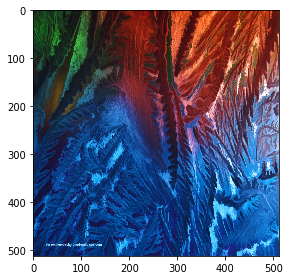

In [58]:
if True:
    img_list = os.listdir('./Dataset/')
    batch_X = []
    batch_Y = []
    for i in range(533, 534):
        X = cv2.imread('./Dataset/' + img_list[i])
        X = cv2.resize(X, (512, 512))
        img = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
        lab_image = rgb2lab(img)
        X = lab_image[:, :, 0].reshape(512, 512, 1)
        Y = lab_image[:, :, 1:]
        batch_X.append(X)
        batch_Y.append(Y)

    print(np.max(batch_X), np.min(batch_X), np.max(batch_Y), np.min(batch_Y), sep='|')
    batch_X = np.asarray(np.asarray(batch_X) / 100.0)
    batch_Y = np.asarray(batch_Y) / 128.0
    print(np.max(batch_X), np.min(batch_X), np.max(batch_Y), np.min(batch_Y), sep='|')
    imshow(img)

In [11]:
def train(num_epochs, decay_rate, decay_steps):

    global loss
    epoch_loss = []

    global_step = tf.Variable(0, trainable=False, name='global_step')
    learning_rate = tf.Variable(1e-3, trainable=False, name='learning_rate')
    inp_img = tf.placeholder(dtype=tf.float32, shape=[None, 512, 512, 1])
    out_img = tf.placeholder(dtype=tf.float32, shape=[None, 512, 512, 2])
    
    sess = tf.Session()
    
    pred = COLOR(inp_img)
    cost = tf.losses.mean_squared_error(pred, out_img)
    tf.summary.scalar('loss', cost)
    
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate)
    tf.summary.scalar('learning_rate', learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    
    merged = tf.summary.merge_all()
    file_writer = tf.summary.FileWriter(logdir=log_dir, graph=sess.graph)
    
    saver = tf.train.Saver(max_to_keep=3)

    if os.path.exists(os.path.join(tmp, 'checkpoint')):
        latest_ckpt = tf.train.latest_checkpoint(tmp)
        saver.restore(sess, latest_ckpt)
    else:
        sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

    image_tensor, label_tensor = read_tf_records(tfrecords[:-1], batch_size=batch_size)

    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    for i in range(num_epochs):
        if i%10 == 0:
            print('%d epoch(s) completed' % i)
        e_loss = 0
        for k in tqdm(range(num_images//batch_size)):

            batch_image, batch_label = sess.run([image_tensor, label_tensor])

            _, j, summary = sess.run([optimizer, cost, merged], 
                                     feed_dict={inp_img: batch_image, out_img: batch_label})
            e_loss += j

            update_op = global_step.assign_add(1)
            sess.run(update_op)
            file_writer.add_summary(summary, global_step.eval(sess))
            loss.append([i*batch_size + k, j])
        
        epoch_loss.append(e_loss)
        if (i>1) and (epoch_loss[-1] < epoch_loss[-2]):
            saver.save(sess, tmp+ckpt_name, global_step.eval(sess))
    coord.request_stop()
    coord.join(threads)
    sess.close()

In [12]:
if True:
    loss = []
    tf.reset_default_graph()
    train(num_epochs=200, decay_rate=0.9 , decay_steps=100)

INFO:tensorflow:Restoring parameters from ./tmp/color-1260


  0%|          | 0/45 [00:00<?, ?it/s]

0 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

10 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

20 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

30 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

40 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

50 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

60 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

70 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

80 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

90 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

100 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

110 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

120 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

130 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

140 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

150 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

160 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

170 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

180 epoch(s) completed


  0%|          | 0/45 [00:00<?, ?it/s]

190 epoch(s) completed


100%|██████████| 45/45 [01:17<00:00,  1.72s/it]


In [59]:
if True:
    loss = np.asarray(loss)
    print('Maximum loss: {}\tMaximum loss at #iteration: {}\nMinimum loss: {}\tMinimum loss at #iteration: {}'
         .format(np.max(loss[:, 1]), np.argmax(loss[:, 1]), np.min(loss[:, 1]), np.argmin(loss[:, 1])))
    print(loss[-1][1])

Maximum loss: 0.04222714528441429	Maximum loss at #iteration: 4015
Minimum loss: 0.00486134784296155	Minimum loss at #iteration: 2248
0.018431691452860832


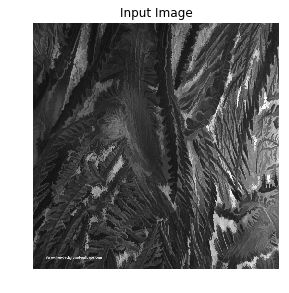

In [60]:
if True:
    grey = rgb2gray(img)
    imshow(grey)
    plt.axis('off')
    plt.title('Input Image')
    plt.savefig('./images/beta/input220_2.png', bbox_inches='tight')
    plt.show()

(1, 512, 512, 2)
INFO:tensorflow:Restoring parameters from ./tmp/color-10260
Maximum and minimum values of input:  99.95044838148273 4.415310311753387
Maximum and minimum values of output:  24.776003 -7.209977
(512, 512, 1) (512, 512, 2)
(512, 512) (512, 512) (512, 512)


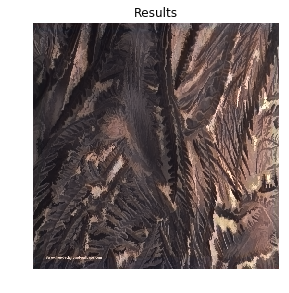

In [61]:
if True:
    tf.reset_default_graph()
    sess = tf.Session()
    output = COLOR(batch_X)
    print(output.shape)
    
    saver = tf.train.Saver()
    latest_ckpt = tf.train.latest_checkpoint(tmp)
    saver.restore(sess, latest_ckpt)
    
    output = sess.run(output)
    output = output * 128.0
    print('Maximum and minimum values of input: ', np.max(X), np.min(X))
    print('Maximum and minimum values of output: ', np.max(output), np.min(output))


    out = np.zeros((512, 512, 3))
    indx = 0
    Y = output[indx]
    print(X.shape, Y.shape)
    print(X[:, :, 0].shape, Y[:, :, 0].shape, Y[:, :, 1].shape)


    out[:, :, 0] = X[:, :, 0]
    out[:, :, 1] = Y[:, :, 0]
    out[:, :, 2] = Y[:, :, 1]
    out = lab2rgb(out)
    imshow(out)
    plt.axis('off')
    plt.title('Results')
    plt.savefig('./images/beta/results220_2.png', bbox_inches='tight')
    plt.show()
    sess.close()

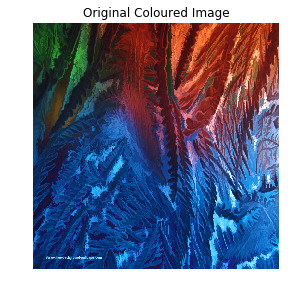

In [62]:
if True:
    grey = rgb2gray(img)
    imshow(img)
    plt.axis('off')
    plt.title('Original Coloured Image')
    plt.savefig('./images/beta/original220_2.png', bbox_inches='tight')
    plt.show()

In [17]:
if False:

    tf.reset_default_graph()
    sess = tf.Session()
    
    inp_img = tf.placeholder(dtype=tf.float32, shape=[None, 512, 512, 1])

    batch_x, batch_y = read_tf_records(tfrecords[-1], batch_size=batch_size)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    batch_image, batch_label = sess.run([batch_x, batch_y])

    pred = COLOR(inp_img)
    
    saver = tf.train.Saver()
    latest_ckpt = tf.train.latest_checkpoint(tmp)
    saver.restore(sess, latest_ckpt)


    output = sess.run(pred, feed_dict={inp_img: batch_image})
    output = output * 128.0

    print('Maximum and minimum values of input: ', np.max(batch_image), np.min(batch_image))
    print('Maximum and minimum values of output: ', np.max(output), np.min(output))


    out = np.zeros((512, 512, 3))
    indx = 0
    X = batch_image[indx]
    Y = output[indx]
    print(X.shape, Y.shape)
    print(X[:, :, 0].shape, Y[:, :, 0].shape, Y[:, :, 1].shape)


    out[:, :, 0] = X[:, :, 0]
    out[:, :, 1] = Y[:, :, 0]
    out[:, :, 2] = Y[:, :, 1]
    out = lab2rgb(out)
    imshow(out)
    sess.close()